<a href="https://colab.research.google.com/github/Shashank-m-m-18/Projects/blob/main/rising%20heart%20attack%20in%20youngsters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
print("Upload either 'clean_results_safe.zip' or 'augmented_heart_youth_clean_perturbed.csv' (zip recommended).")
uploaded = files.upload()


Upload either 'clean_results_safe.zip' or 'augmented_heart_youth_clean_perturbed.csv' (zip recommended).


Saving augmented_heart_youth_clean_perturbed.csv to augmented_heart_youth_clean_perturbed.csv


In [2]:
import zipfile, os, glob
zip_name = None
for name in uploaded.keys():
    if name.lower().endswith('.zip'):
        zip_name = name
        break
if zip_name:
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall('.')
    print("Extracted:", zip_name)

print("Files in working directory (first 200):")
print(glob.glob("*")[:200])


Files in working directory (first 200):
['augmented_heart_youth_clean_perturbed.csv', 'sample_data']


In [3]:
# Training script (cleaned dataset). Edit filenames below if needed.
import os, json, pickle, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

np.random.seed(42)

# Local filenames (after upload/extract)
AUG_PATH = "augmented_heart_youth_clean_perturbed.csv"   # default file produced by the pipeline
MODELS_DIR = "models"
PLOTS_DIR = "plots"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# fallback: detect common alternate names
if not os.path.exists(AUG_PATH):
    for alt in ["augmented_heart_youth.csv","augmented_heart_youth_clean.csv","augmented_heart_youth_clean_perturbed.csv"]:
        if os.path.exists(alt):
            AUG_PATH = alt
            break
if not os.path.exists(AUG_PATH):
    raise FileNotFoundError(f"Could not find dataset. Please upload '{AUG_PATH}' or a ZIP containing it. Current dir: {os.listdir('.')}")

print("Loading dataset:", AUG_PATH)
df = pd.read_csv(AUG_PATH)

# Leak protection: drop any column exactly equal to target
if 'target' not in df.columns:
    raise ValueError("The dataset must include a 'target' column (0/1).")
leak_cols = [c for c in df.columns if c!='target' and df[c].equals(df['target'])]
if leak_cols:
    print("Dropping leaked columns:", leak_cols)
    df.drop(columns=leak_cols, inplace=True)

# Identify synthetic columns heuristically
possible_synth = ['sleep_hours','sleep_consistency','hrv_mean','hrv_sd','stress_index',
                  'physical_activity_mins','screen_time_hours','mental_health_score','aqi','recent_illness','smoker','alcohol_units_week']
synthetic_cols = [c for c in possible_synth if c in df.columns]

# Select clinical columns (common clinical names)
clinical_candidates = ['Age','age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','trestbps','thalach','chol']
clinical_cols = [c for c in clinical_candidates if c in df.columns]
if len(clinical_cols) < 2:
    # fallback: pick numeric cols excluding target and synthetic
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    clinical_cols = [c for c in numeric if c not in synthetic_cols and c!='target'][:6]

lifestyle_cols = [c for c in synthetic_cols if c in df.columns]

print("Clinical cols:", clinical_cols)
print("Lifestyle cols (detected):", lifestyle_cols)
print("Rows:", len(df))

X_clin = df[clinical_cols].fillna(df[clinical_cols].median())
X_all = df[clinical_cols + lifestyle_cols].fillna(0)
y = df['target']

# Memory-safe CV training
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs_clin = []; aucs_all = []
last_probs = {}
fold = 0
for tr, te in skf.split(X_all, y):
    fold += 1
    Xc_tr, Xc_te = X_clin.iloc[tr], X_clin.iloc[te]
    Xa_tr, Xa_te = X_all.iloc[tr], X_all.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    rf_c = RandomForestClassifier(n_estimators=50, max_depth=6, n_jobs=1, random_state=42).fit(Xc_tr, y_tr)
    p_c = rf_c.predict_proba(Xc_te)[:,1]
    auc_c = roc_auc_score(y_te, p_c)
    aucs_clin.append(auc_c)
    rf_all = RandomForestClassifier(n_estimators=50, max_depth=6, n_jobs=1, random_state=42).fit(Xa_tr, y_tr)
    p_a = rf_all.predict_proba(Xa_te)[:,1]
    auc_a = roc_auc_score(y_te, p_a)
    aucs_all.append(auc_a)
    if fold == 5:
        last_probs['p_c'] = p_c; last_probs['p_a'] = p_a; last_probs['y_te'] = y_te
        pickle.dump(rf_c, open(os.path.join(MODELS_DIR,"rf_clin_final_safe.pkl"),"wb"))
        pickle.dump(rf_all, open(os.path.join(MODELS_DIR,"rf_all_final_safe.pkl"),"wb"))

metrics = {
    "clinical_rf_auc_mean": float(np.mean(aucs_clin)),
    "clinical_rf_auc_std": float(np.std(aucs_clin)),
    "all_rf_auc_mean": float(np.mean(aucs_all)),
    "all_rf_auc_std": float(np.std(aucs_all)),
    "n_rows": int(len(df)),
    "clinical_cols_used": clinical_cols,
    "lifestyle_cols_used": lifestyle_cols
}
with open(os.path.join(MODELS_DIR,"clean_metrics_safe.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# ROC plot for final fold
fpr_c, tpr_c, _ = roc_curve(last_probs['y_te'], last_probs['p_c'])
fpr_a, tpr_a, _ = roc_curve(last_probs['y_te'], last_probs['p_a'])
plt.figure(figsize=(6,5))
plt.plot(fpr_c, tpr_c, label=f"RF_clin (AUC={roc_auc_score(last_probs['y_te'], last_probs['p_c']):.3f})")
plt.plot(fpr_a, tpr_a, label=f"RF_all (AUC={roc_auc_score(last_probs['y_te'], last_probs['p_a']):.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.3)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC (final fold) - Cleaned data")
plt.legend(loc="lower right")
roc_path = os.path.join(PLOTS_DIR,"roc_clean_final_safe.png")
plt.tight_layout(); plt.savefig(roc_path); plt.close()
print("Saved ROC to", roc_path)

# Feature importances
rf_all = pickle.load(open(os.path.join(MODELS_DIR,"rf_all_final_safe.pkl"),"rb"))
if hasattr(rf_all, "feature_importances_"):
    feat_names = X_all.columns.tolist()
    imp = rf_all.feature_importances_
    imp_series = pd.Series(imp, index=feat_names).sort_values(ascending=False)
    imp_series.head(20).to_csv(os.path.join(MODELS_DIR,"feature_importances_clean_safe.csv"))
    plt.figure(figsize=(8,6)); imp_series.head(20).plot(kind='bar'); plt.title("Top 20 feature importances (cleaned safe RF)")
    fi_path = os.path.join(PLOTS_DIR,"feature_importance_clean_safe.png")
    plt.tight_layout(); plt.savefig(fi_path); plt.close()
    print("Saved feature importance to", fi_path)

print("\\nDone. Metrics saved to models/clean_metrics_safe.json and plots in plots/.")


Loading dataset: augmented_heart_youth_clean_perturbed.csv
Clinical cols: ['Age', 'age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Lifestyle cols (detected): ['sleep_hours', 'sleep_consistency', 'hrv_mean', 'hrv_sd', 'stress_index', 'physical_activity_mins', 'screen_time_hours', 'mental_health_score', 'aqi', 'recent_illness', 'smoker', 'alcohol_units_week']
Rows: 918
Saved ROC to plots/roc_clean_final_safe.png
Saved feature importance to plots/feature_importance_clean_safe.png
\nDone. Metrics saved to models/clean_metrics_safe.json and plots in plots/.


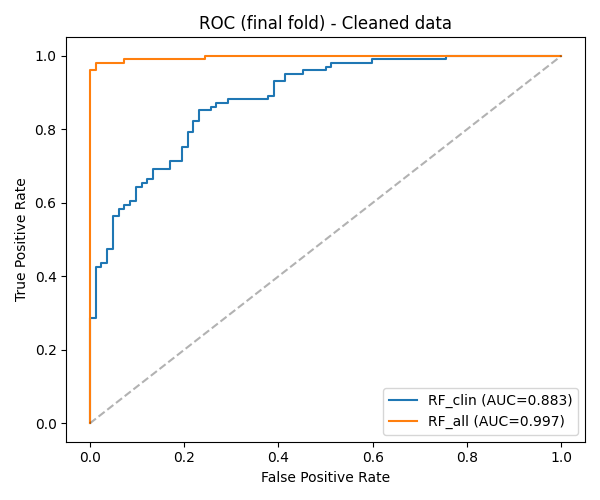

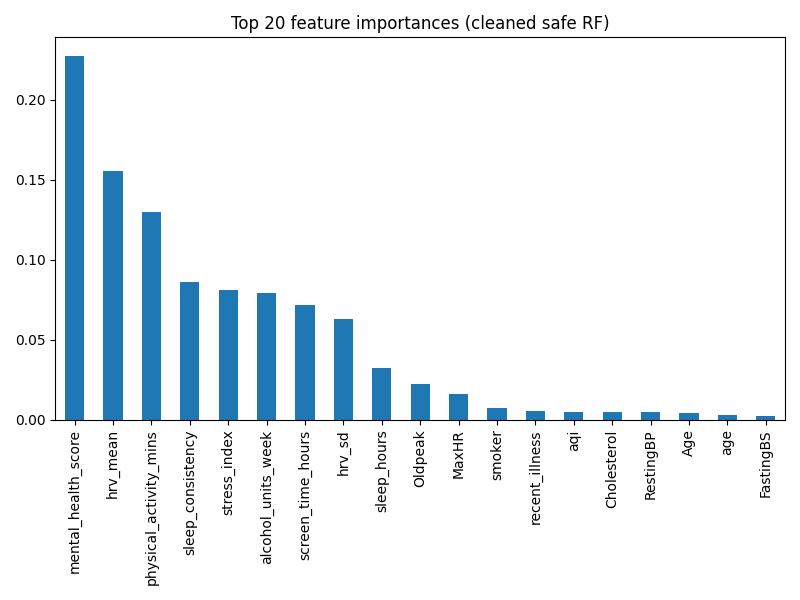

In [4]:
from IPython.display import Image, display
display(Image("plots/roc_clean_final_safe.png"))
display(Image("plots/feature_importance_clean_safe.png"))
